In [28]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [29]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2
TEXT_DATA = 'dataset.csv'

In [30]:
df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]
print(df)

                                                   text label
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE
2     U.S. Secretary of State John F. Kerry said Mon...  REAL
3     — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE
4     It's primary day in New York and front-runners...  REAL
...                                                 ...   ...
6330  The State Department told the Republican Natio...  REAL
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  FAKE
6332   Anti-Trump Protesters Are Tools of the Oligar...  FAKE
6333  ADDIS ABABA, Ethiopia —President Obama convene...  REAL
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  REAL

[6335 rows x 2 columns]


In [23]:
from keras.preprocessing.text import Tokenizer
tok = Tokenizer()
# train tokenizer
tok.fit_on_texts(["it was not good, it was actually quite bad"]) 
# print sequences
print(tok.texts_to_sequences(["it was not good, it was actually quite bad"])[0]) 
print(tok.texts_to_sequences(["it was not bad, it was actually quite good"])[0])

[1, 2, 3, 4, 1, 2, 5, 6, 7]
[1, 2, 3, 7, 1, 2, 5, 6, 4]


In [32]:
from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [33]:
from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [34]:
texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


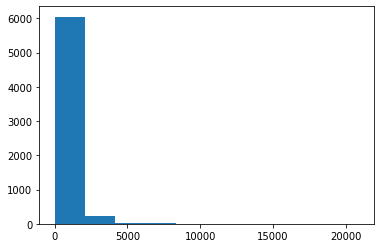

In [35]:

# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [38]:

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [39]:
from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         7500300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 135s 27ms/step - loss: 0.4740 - acc: 0.7932 - val_loss: 0.2236 - val_acc: 0.9321
Epoch 2/10
5068/5068 [==============================] - 434s 86ms/step - loss: 0.1378 - acc: 0.9592 - val_loss: 0.1454 - val_acc: 0.9448
Epoch 3/10
5068/5068 [==============================] - 125s 25ms/step - loss: 0.0342 - acc: 0.9955 - val_loss: 0.1146 - val_acc: 0.9542
Epoch 4/10
5068/5068 [==============================] - 622s 123ms/step - loss: 0.0065 - acc: 0.9996 - val_loss: 0.1055 - val_acc: 0.9605
Epoch 5/10
5068/5068 [==============================] - 124s 24ms/step - loss: 8.4135e-04 - acc: 1.0000 - val_loss: 0.0818 - val_acc: 0.9700
Epoch 6/10
5068/5068 [==============================] - 127s 25ms/step - loss: 1.1183e-04 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9716
Epoch 7/10
5068/5068 [==============================] - 127s 25ms/step - loss: 1.3191e-05 - acc: 1.0000 - val_loss: 0.09

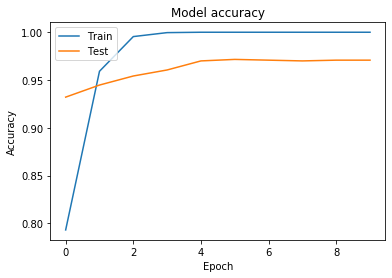

In [41]:
# Plot training & validation accuracy values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:

# evaluate model

def predict(X):
    return np.rint(model.predict(X)) # threshold the predictions to retrieve labels

train_acc, test_acc = evaluate_model(predict,
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 97.08%
